###import


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gluonnlp pandas tqdm   
!pip install mxnet
!pip install sentencepiece==0.1.91
!pip install transformers==4.8.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 2.3 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 15.3 MB/s 
     |████████████████████████████████| 880 kB 67.0 MB/s 
     |████████████████████████████████| 3.3 MB 56.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=ae9366de63ebf72a62dfc01b3a70be49159006b1e965f1e03c9234d1

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# import gluonnlp as nlp
import numpy as np
import pandas as pd
import matplotlib as plt
from tqdm.notebook import tqdm

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### train data 불러오기

In [ ]:
# train data
rev_data= pd.read_csv('/content/drive/MyDrive/딥러닝개론/data/rev_data.csv')
shopping_rev= pd.read_csv('/content/drive/MyDrive/딥러닝개론/data/shopping_rev.csv')

### Training with rev data

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-gt5nt1jm
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-gt5nt1jm
     |████████████████████████████████| 129 kB 14.6 MB/s 
     |████████████████████████████████| 54.7 MB 39 kB/s 
     |████████████████████████████████| 4.5 MB 57.5 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x39c2c000 @  0x7fec7417e615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |████████████████████████████████| 881.9 MB 8.3 kB/s 
     |████████████████████████████████| 2.5 MB 5

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
# train data -> data list
data_list = []
for ques, label in zip(rev_data['review'], rev_data['binary'])  :
    data = []   
    data.append(ques)
    data.append(str(label))

    data_list.append(data)

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, shuffle=True, random_state=34)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
# data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

# train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
# test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [ ]:
# train 
## 20 more!!!
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

    torch.save(model, '/content/drive/MyDrive/딥러닝개론/checkpoint/kobert_checkpoint_ep_%d.pt'%e)

### train with rev data, shopping rev

In [ ]:
### shopping rev size 줄이기; 20만개 -> 1만개
shopping_rev_cut = shopping_rev[:10000]

In [ ]:
reviews = pd.concat([rev_data, shopping_rev_cut], axis=0)
reviews

,Unnamed: 0,review,score,binary,trinary
0,0,친절하시고 깔끔하고 좋았습니다,5,1,2
1,1,조용하고 고기도 굿,5,1,2
2,2,"갈비탕과 냉면, 육회비빔밥이 맛있습니다.",4,1,2
3,3,대체적으로 만족하나\n와인의 구성이 살짝 아쉬움,4,1,2
4,4,고기도 맛있고 서비스는 더 최고입니다~,5,1,2
...,...,...,...,...,...
9995,9995,기대를 너무 많이했나봐요 ........ 일단 머릿결 상하신 분은 고민좀 해보세요 ...,1,0,0
9996,9996,너무 귀엽고 폭신폭신하고 예뻐요,5,1,2
9997,9997,눈뒤에 실거는부분이커서 다뜨고 눈을붙일수가없네요 ㅜ,1,0,0
9998,9998,짜증 옷이 뒤틀려서 왔음. 짜증 ㄷ신ㅅㅇㅌㄹ츤ㅅㄴㅅㅌㅅ가ㅡㅡㅎㄱㄴㅅ듣ㅅㄱᆞㄷ쑈는핟ㅎ...,2,0,0


In [ ]:
data_list = []
for ques, label in zip(reviews['review'], reviews['binary'])  :
    data = []   
    data.append(ques)
    data.append(str(label))

    data_list.append(data)

In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, shuffle=True, random_state=34)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  data = _utils.pin_memory.pin_memory(data)


In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [ ]:
# model = torch.load('/content/drive/MyDrive/딥러닝개론/checkpoint/more_kobert_checkpoint_ep_15.pt', map_location="cuda:0")
# model.to(device)

# model.train()

In [ ]:
best_acc = 0
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model, '/content/drive/MyDrive/딥러닝개론/checkpoint/kobert_all_checkpoint_ep_%d.pt'%e)
        print('Model Saved.')
    

  0%|          | 0/267 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  data = _utils.pin_memory.pin_memory(data)


epoch 1 batch id 1 loss 0.6936715245246887 train acc 0.640625
epoch 1 batch id 201 loss 0.3679993152618408 train acc 0.6812033582089553
epoch 1 train acc 0.7252547896859695


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 1 test acc 0.8928728070175438
Model Saved.


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.2151831090450287 train acc 0.9375
epoch 2 batch id 201 loss 0.21251827478408813 train acc 0.8804415422885572
epoch 2 train acc 0.8853626476519736


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 2 test acc 0.894078947368421
Model Saved.


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.1657569259405136 train acc 0.921875
epoch 3 batch id 201 loss 0.1880367249250412 train acc 0.9201648009950248
epoch 3 train acc 0.9224061869778162


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 3 test acc 0.9232456140350876
Model Saved.


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.024290956556797028 train acc 1.0
epoch 4 batch id 201 loss 0.09335173666477203 train acc 0.9469838308457711
epoch 4 train acc 0.9479211682512245


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 4 test acc 0.911266447368421


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.0904829204082489 train acc 0.9375
epoch 5 batch id 201 loss 0.21634002029895782 train acc 0.9565453980099502
epoch 5 train acc 0.9565236963411121


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 5 test acc 0.9195997807017543


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.011596386320888996 train acc 1.0
epoch 6 batch id 201 loss 0.08714412897825241 train acc 0.9686722636815921
epoch 6 train acc 0.9703300561797753


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 6 test acc 0.9262061403508771
Model Saved.


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.036941640079021454 train acc 0.984375
epoch 7 batch id 201 loss 0.031620126217603683 train acc 0.9770677860696517
epoch 7 train acc 0.9773570296744454


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 7 test acc 0.9215186403508772


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.010420996695756912 train acc 1.0
epoch 8 batch id 201 loss 0.03200487419962883 train acc 0.9821206467661692
epoch 8 train acc 0.9811563670411985


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 8 test acc 0.919078947368421


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.0140791991725564 train acc 1.0
epoch 9 batch id 201 loss 0.08245357871055603 train acc 0.9878731343283582
epoch 9 train acc 0.9873010299625468


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 9 test acc 0.928453947368421
Model Saved.


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.006104919593781233 train acc 1.0
epoch 10 batch id 201 loss 0.003956868778914213 train acc 0.9891946517412935
epoch 10 train acc 0.9885299625468165


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 10 test acc 0.9242872807017544


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.04386525601148605 train acc 0.984375
epoch 11 batch id 201 loss 0.11481858044862747 train acc 0.9918376865671642
epoch 11 train acc 0.9919826779026217


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 11 test acc 0.9279331140350877


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.004803935997188091 train acc 1.0
epoch 12 batch id 201 loss 0.054383616894483566 train acc 0.9936256218905473
epoch 12 train acc 0.9937382958801498


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 12 test acc 0.9232456140350876


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.004035549703985453 train acc 1.0
epoch 13 batch id 201 loss 0.0010903284419327974 train acc 0.9943252487562189
epoch 13 train acc 0.9946161048689138


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 13 test acc 0.9263706140350877


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.006234786938875914 train acc 1.0
epoch 14 batch id 201 loss 0.0034149736166000366 train acc 0.9956467661691543
epoch 14 train acc 0.9959620786516854


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 14 test acc 0.928453947368421


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.005374043248593807 train acc 1.0
epoch 15 batch id 201 loss 0.0017504784045740962 train acc 0.996113184079602
epoch 15 train acc 0.9962546816479401


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 15 test acc 0.9263706140350877


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.007211172953248024 train acc 1.0
epoch 16 batch id 201 loss 0.0005306489183567464 train acc 0.9972014925373134
epoch 16 train acc 0.9971910112359551


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 16 test acc 0.9289747807017543
Model Saved.


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.004405510611832142 train acc 1.0
epoch 17 batch id 201 loss 0.0004598612431436777 train acc 0.9982120646766169
epoch 17 train acc 0.9979517790262172


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 17 test acc 0.928453947368421


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.0035676443949341774 train acc 1.0
epoch 18 batch id 201 loss 0.0004519597569014877 train acc 0.998056592039801
epoch 18 train acc 0.9979517790262172


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 18 test acc 0.926891447368421


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.004059135913848877 train acc 1.0
epoch 19 batch id 201 loss 0.00043957887100987136 train acc 0.9985230099502488
epoch 19 train acc 0.9983029026217228


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 19 test acc 0.9294956140350876
Model Saved.


  0%|          | 0/267 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.004893473349511623 train acc 1.0
epoch 20 batch id 201 loss 0.0004504325916059315 train acc 0.9982120646766169
epoch 20 train acc 0.9980102996254682


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 20 test acc 0.9289747807017543


### predict

In [ ]:
# test data 불러오기
test = pd.read_csv('/content/drive/MyDrive/딥러닝개론/data/predict_split.csv')
test

,Unnamed: 0,식당 인덱스,리뷰,review_split
0,0,0,저렴한 전집이지만 바로 부쳐주시니 맛은 보장됩니다. 조금씩 시켜먹기 좋게 메뉴판 구...,"['저렴한 전집이지만 바로 부쳐주시니 맛은 보장됩니다.', '조금씩 시켜먹기 좋게 ..."
1,1,0,굿ㅇ,['굿ㅇ']
2,2,0,친절해요,['친절해요']
3,3,0,친절해요,['친절해요']
4,4,0,굿,['굿']
...,...,...,...,...
112548,112548,1047,생활의 달인 방송후 다음날 갔는데.. 겨우 구입했어요!!\n진짜 쫀득쫀득하니 맛있네요^^,"['생활의 달인 방송후 다음날 갔는데..', '겨우 구입했어요!!', '\\n진짜 ..."
112549,112549,1047,떡이 맛있어요~,['떡이 맛있어요~']
112550,112550,1047,사장님도 너무친절하시고 떡도 너무 맛있어요 ㅎㅎ 아침용으로 하나씩 챙겨먹을때도있고 ...,"['사장님도 너무친절하시고 떡도 너무 맛있어요 ㅎㅎ', '아침용으로 하나씩 챙겨먹을..."
112551,112551,1047,떡이 종류가 별루없네요.직접만드는거같아요\n가래떡샀는데 따뜻하네요~,"['떡이 종류가 별루없네요.', '직접만드는거같아요', '\\n가래떡샀는데 따뜻하네..."


In [ ]:
# 식당 50개만 추출, nan 제거
test_50 = test[test['식당 인덱스']<=49]
test_50_drop=test_50.dropna(subset=['review_split'], how='any', axis=0)

In [ ]:
model = torch.load('/content/drive/MyDrive/딥러닝개론/checkpoint/kobert_all_checkpoint_ep_18.pt')
model=model.to(device)
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def new_softmax(a) : 
    c = np.max(a) # 최댓값
    exp_a = np.exp(a-c) # 각각의 원소에 최댓값을 뺀 값에 exp를 취한다. (이를 통해 overflow 방지)
    sum_exp_a = np.sum(exp_a)
    y = (exp_a / sum_exp_a) * 100
    return np.round(y, 3)


# 예측 모델 설정
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)
        
        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            min_v = min(logits)
            total = 0
            probability = []
            logits = np.round(new_softmax(logits), 3).tolist()
            for logit in logits:
                # print(logit)
                probability.append(np.round(logit, 3))

            if np.argmax(logits) == 0:  emotion = "부정"
            elif np.argmax(logits) == 1: emotion = "긍정"

            probability.append(emotion)
            # print(probability)
            positive = logits[1] ##
    #return probability
    return positive

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
sentence = test_50_drop['review_split']

In [ ]:
### 끊어서 계산하기.. 일단 12개
sentence = test_50_drop[test_50_drop['식당 인덱스']>=13]['review_split']
sentence

2971                            ['삼계탕과 갈비탕의 맛과 가성비가 좋아요']
2972                                     ['국밥 뜨끈하니 맛있어요']
2973                                         ['가성비가 좋아요']
2974                                           ['가성비좋아요']
2975                         ['와송삼계탕과 소고기수육이 맛나는 단골집입니다']
                              ...                        
6947                                             ['맛있어요']
6948                                            ['굿~!!!']
6949                                           ['보통이에요~']
6950                                          ['보통의 한식집']
6951    ['닭한마리, 닭볶음땅, 찜닭, 닭계장 등 닭 전문요리와 그외 백반찌개류도 있다.'...
Name: review_split, Length: 3976, dtype: object

#### predict and save result

In [ ]:
score_all = []
for l in tqdm(sentence):
  l = eval(l)
  score_list=[]
  for s in l:
    score_list.append(predict(s))
  score_all.append(score_list)

  0%|          | 0/3976 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  data = _utils.pin_memory.pin_memory(data)


In [ ]:
## array를 열로 추가//끊어서 학습할 때 사용
score_all
score_0_49 = np.array(score_all)
score_0_49 = pd.DataFrame(score_0_49)
score_0_49.to_csv('/content/drive/MyDrive/딥러닝개론/all_score_13_49.csv')

<ipython-input-18-43df71fa1e5f>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score_0_49 = np.array(score_all)


In [ ]:
# ## array를 열로 추가
# score_all
# score_0_49 = np.array(score_all)
# score_0_49 = pd.DataFrame(score_0_49)
# score_0_49.to_csv('/content/drive/MyDrive/딥러닝개론/all_score_0_49.csv')

In [ ]:
### 점수 저장해둔거 불러오기
all_score_0_12 = pd.read_csv('/content/drive/MyDrive/딥러닝개론/all_score_0_12.csv')
all_score_13_49 = pd.read_csv('/content/drive/MyDrive/딥러닝개론/all_score_13_49.csv')
score_0_49 = pd.concat([all_score_0_12, all_score_13_49])

In [ ]:
score_0_49.to_csv('/content/drive/MyDrive/딥러닝개론/all_score.csv')

In [ ]:
score_0_49

In [ ]:
## test_50_drop 인덱스 리셋, score 결과 붙이기
test_result = test_50_drop.reset_index(drop=True)
# score_0_49 = score_0_49.reset_index(drop=True)
test_result = test_result.drop('Unnamed: 0', axis=1)
test_score = pd.concat([test_result,score_0_49],axis=1)

In [ ]:
## 결과 저장
test_score.to_csv('/content/drive/MyDrive/딥러닝개론/all_test_score.csv')

#### score - rev data

In [ ]:
test_score = pd.read_csv('/content/drive/MyDrive/딥러닝개론/test_score.csv')
test_score = test_score[['식당 인덱스','0']]
test_score = test_score.rename(columns={'0':'scores'})
test_score

,식당 인덱스,scores
0,0,"[98.78900146484375, 99.5199966430664]"
1,0,[97.95899963378906]
2,0,[97.81999969482422]
3,0,[97.81999969482422]
4,0,[95.72100067138672]
...,...,...
6935,49,[74.14800262451172]
6936,49,[99.28500366210938]
6937,49,[0.3799999952316284]
6938,49,[0.3959999978542328]


In [ ]:
test_score = test_score.assign(rev_score=np.nan)
test_score

In [ ]:
# 각 리뷰별 점수 계산
for i, s in enumerate(test_score['scores']):
  s = eval(s)
  test_score.iloc[i,2] = sum(s)/len(s)

In [ ]:
test_score

,식당 인덱스,scores,rev_score
0,0,"[98.78900146484375, 99.5199966430664]",99.154499
1,0,[97.95899963378906],97.959000
2,0,[97.81999969482422],97.820000
3,0,[97.81999969482422],97.820000
4,0,[95.72100067138672],95.721001
...,...,...,...
6935,49,[74.14800262451172],74.148003
6936,49,[99.28500366210938],99.285004
6937,49,[0.3799999952316284],0.380000
6938,49,[0.3959999978542328],0.396000


In [ ]:
# 식당별 점수 구하기
kobert_result = test_score.groupby('식당 인덱스').rev_score.mean()*0.05
kobert_result

식당 인덱스
0     4.500223
1     4.090109
2     4.208210
3     4.566058
4     3.625671
5     4.142724
6     4.353873
7     4.136362
8     3.650227
9     4.438721
10    4.226084
11    4.275167
12    3.675011
13    3.980364
14    3.698035
15    4.436715
16    3.981022
17    4.292157
18    4.012980
19    3.967234
20    4.817411
21    4.312874
22    4.194625
23    4.162342
24    3.777862
25    4.347256
26    4.334700
27    3.563880
28    4.472410
29    4.429119
30    4.652734
31    4.435728
32    4.820244
33    4.385717
34    4.237519
35    4.157643
36    3.957616
37    4.256992
38    4.749946
39    4.210855
40    4.321532
41    4.069096
42    4.199448
43    4.355613
44    2.011750
45    4.253821
46    3.931405
47    4.252025
48    4.273871
49    4.083338
Name: rev_score, dtype: float64

In [ ]:
kobert_result.to_csv('/content/drive/MyDrive/딥러닝개론/kobert_result_revdata.csv')

#### score - rev data + shopping rev

In [ ]:
test_score = pd.read_csv('/content/drive/MyDrive/딥러닝개론/all_test_score.csv')
test_score = test_score[['식당 인덱스','0']]
test_score = test_score.rename(columns={'0':'scores'})
test_score

,식당 인덱스,scores
0,0,"[99.96600341796875, 99.97799682617188]"
1,0,[95.625]
2,0,[87.00900268554688]
3,0,[87.00900268554688]
4,0,[82.00499725341797]
...,...,...
6935,49,[80.84600067138672]
6936,49,[99.9739990234375]
6937,49,[0.028999999165534973]
6938,49,[0.028999999165534973]


In [ ]:
test_score = test_score.assign(rev_score=np.nan)
test_score

,식당 인덱스,scores,rev_score
0,0,"[99.96600341796875, 99.97799682617188]",NaN
1,0,[95.625],NaN
2,0,[87.00900268554688],NaN
3,0,[87.00900268554688],NaN
4,0,[82.00499725341797],NaN
...,...,...,...
6935,49,[80.84600067138672],NaN
6936,49,[99.9739990234375],NaN
6937,49,[0.028999999165534973],NaN
6938,49,[0.028999999165534973],NaN


In [ ]:
# 각 리뷰별 점수 계산
for i, s in enumerate(test_score['scores']):
  s = eval(s)
  test_score.iloc[i,2] = sum(s)/len(s)

In [ ]:
test_score

,식당 인덱스,scores,rev_score
0,0,"[99.96600341796875, 99.97799682617188]",99.972000
1,0,[95.625],95.625000
2,0,[87.00900268554688],87.009003
3,0,[87.00900268554688],87.009003
4,0,[82.00499725341797],82.004997
...,...,...,...
6935,49,[80.84600067138672],80.846001
6936,49,[99.9739990234375],99.973999
6937,49,[0.028999999165534973],0.029000
6938,49,[0.028999999165534973],0.029000


In [ ]:
# 식당별 점수 구하기
kobert_result = test_score.groupby('식당 인덱스').rev_score.mean()*0.05
kobert_result

식당 인덱스
0     4.336189
1     4.031929
2     4.061061
3     4.595552
4     3.546373
5     4.062935
6     4.388958
7     4.010662
8     3.437606
9     4.341433
10    4.206470
11    4.308649
12    3.520303
13    4.296961
14    3.558757
15    4.678568
16    3.977720
17    4.405977
18    3.979489
19    4.023502
20    4.025098
21    4.128149
22    3.997385
23    4.481449
24    4.121830
25    4.274612
26    4.520600
27    3.539895
28    4.559105
29    4.365800
30    4.654888
31    4.456947
32    4.674579
33    4.231855
34    3.975459
35    4.502128
36    3.771337
37    4.222263
38    4.600951
39    4.091559
40    4.114140
41    3.930216
42    4.123270
43    4.385750
44    0.001800
45    4.446803
46    3.847472
47    4.089999
48    3.902128
49    3.894121
Name: rev_score, dtype: float64

In [ ]:
kobert_result.to_csv('/content/drive/MyDrive/딥러닝개론/kobert_result_rev+shop.csv')

### rev_data만 사용, shopping rev까지 사용 결과 비교

In [ ]:
kobert_revdata = pd.read_csv('/content/drive/MyDrive/딥러닝개론/result/kobert_result_revdata.csv')
kobert_rev_shop = pd.read_csv('/content/drive/MyDrive/딥러닝개론/result/kobert_result_rev+shop.csv')
existing_info = pd.read_csv('/content/drive/MyDrive/딥러닝개론/data/total_info.csv')

In [ ]:
existing_score = existing_info['별점'][:50]

In [ ]:
result = pd.merge(kobert_revdata, kobert_rev_shop, on='식당 인덱스')
result = result.rename(columns={'rev_score_x':'rev_score_1', 'rev_score_y':'rev_score_2'})
result = pd.concat([result, existing_score], axis=1)
result

,식당 인덱스,rev_score_1,rev_score_2,별점
0,0,4.500223,4.336189,4.27
1,1,4.090109,4.031929,4.29
2,2,4.208210,4.061061,4.42
3,3,4.566058,4.595552,4.53
4,4,3.625671,3.546373,4.18
5,5,4.142724,4.062935,4.39
6,6,4.353873,4.388958,4.43
7,7,4.136362,4.010662,NaN
8,8,3.650227,3.437606,4.31
9,9,4.438721,4.341433,4.27


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

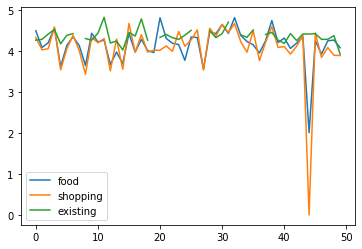

In [ ]:
plt.plot(result['식당 인덱스'],result['rev_score_1'])
plt.plot(result['식당 인덱스'],result['rev_score_2'])
plt.plot(result['식당 인덱스'],result['별점'])
plt.legend(['food','shopping','existing'])

### KoBERT, GPT 비교

In [ ]:
## train data: rev+shop
kobert = pd.read_csv('/content/drive/MyDrive/딥러닝개론/result/kobert_result_rev+shop.csv')
kogpt = pd.read_csv('/content/drive/MyDrive/딥러닝개론/result/kogpt_shopo_final_result_5.csv')

In [ ]:
kobert

In [ ]:
kogpt

In [ ]:
existing_info = pd.read_csv('/content/drive/MyDrive/딥러닝개론/data/total_info.csv')
existing_score = existing_info['별점'][:50]

In [ ]:
total = pd.concat([kobert,kogpt,existing_score],axis=1).drop(labels='index',axis=1)
total

,식당 인덱스,rev_score,score,별점
0,0.0,4.336189,4.045090,4.27
1,1.0,4.031929,4.059857,4.29
2,2.0,4.061061,3.955623,4.42
3,3.0,4.595552,4.103023,4.53
4,4.0,3.546373,3.645212,4.18
5,5.0,4.062935,4.202253,4.39
6,6.0,4.388958,4.293836,4.43
7,7.0,4.010662,4.107851,NaN
8,8.0,3.437606,3.348686,4.31
9,9.0,4.341433,4.449203,4.27


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

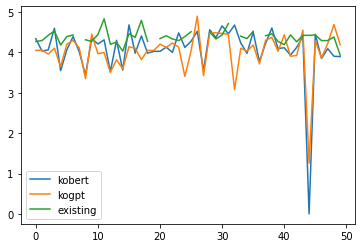

In [ ]:
plt.plot(total['식당 인덱스'],total['rev_score'])
plt.plot(total['식당 인덱스'],total['score'])
plt.plot(total['식당 인덱스'],total['별점'])
plt.legend(['kobert','kogpt','existing'])

In [ ]:
kobert_d = total['rev_score'].drop(44)
kogpt_d = total['score'].drop(44)

# mean, std
print("kobert_mean: ",np.mean(kobert_d), "kogpt_mean: ",np.mean(kogpt_d))
print("kobert_std: ",np.std(kobert_d), "kogpt_std: ",np.std(kogpt_d))

kobert_mean:  4.157120096707425 kogpt_mean:  4.074089166132208
kobert_std:  0.3164468628328499 kogpt_std:  0.3495417951912715


In [ ]:
kobert_d = total['rev_score'].drop(44)
kogpt_d = total['score'].drop(44).dropna()

# mean, std
print("kobert_mean: ",np.mean(kobert_d), "kogpt_mean: ",np.mean(kogpt_d))
print("kobert_std: ",np.std(kobert_d), "kogpt_std: ",np.std(kogpt_d))

kobert_mean:  4.157120096707425 kogpt_mean:  4.074089166132208
kobert_std:  0.3164468628328499 kogpt_std:  0.3495417951912715


In [ ]:
print("kobert score is lower: ", sum(kobert_d < kogpt_d))
print("kogpt score is lower: ",sum(kobert_d > kogpt_d))

kobert score is lower:  21
kogpt score is lower:  28


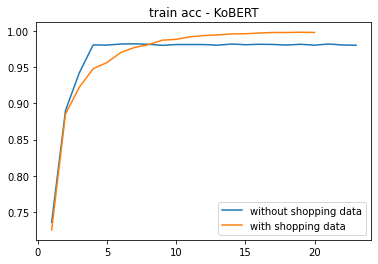

In [ ]:
# from matplotlib import pyplot as plt

# train acc
x = list(range(1,24))
x2 = list(range(1,21))
y = [0.7359066655941656,0.8901055072930073,0.9424033408408409,0.9808122854997855,0.9805642696267696,0.9820523648648648,0.9823003807378807,0.981680341055341,0.9801922458172457,0.9813083172458172,0.981341832904333,0.9813083172458172,0.9804402616902617,0.9820523648648648,0.9810603013728013,0.981680341055341,0.9814323251823251,0.9805977852852853,0.9817138567138568,0.9804402616902617,0.9820523648648648,0.9807217932217933,0.9803497694122695]
y2= [0.7252547896859695,0.8853626476519736,0.9224061869778162,0.9479211682512245,0.9565236963411121,0.9703300561797753,0.9773570296744454,0.9811563670411985,0.9873010299625468,0.9885299625468165,0.9919826779026217,0.9937382958801498,0.9946161048689138,0.9959620786516854,0.9962546816479401,0.9971910112359551,0.9979517790262172,0.9979517790262172,0.9983029026217228,0.9980102996254682]
plt.plot(x,y)
plt.plot(x2,y2)
plt.title("train acc - KoBERT")
plt.legend(['without shopping data','with shopping data'])
plt.show()

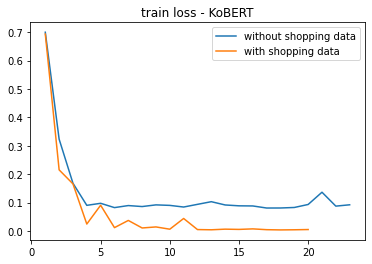

In [ ]:
# train loss
x = list(range(1,24))
x2 = list(range(1,21))
y = [0.7000827193260193,0.32329437136650085,0.16798962652683258,0.09016193449497223,0.09733905643224716,0.08216632902622223,0.0893615260720253,0.08589108288288116,0.0917963907122612,0.09001083672046661,0.08420572429895401,0.09367308020591736,0.10302820056676865,0.09148695319890976,0.08847251534461975,0.08798583596944809,0.08070933818817139,0.08081385493278503,0.08263897895812988,0.09320462495088577,0.13639375567436218,0.08739761263132095,0.09208507835865021]
y2 = [0.6936715245246887,0.2151831090450287,0.1657569259405136,0.024290956556797028,0.0904829204082489,0.011596386320888996,0.036941640079021454,0.010420996695756912,0.0140791991725564,0.006104919593781233,0.04386525601148605,0.004803935997188091,0.004035549703985453,0.006234786938875914,0.005374043248593807,0.007211172953248024,0.004405510611832142,0.0035676443949341774,0.004059135913848877,0.004893473349511623]
plt.plot(x,y)
plt.plot(x2,y2)
plt.title("train loss - KoBERT")
plt.legend(['without shopping data','with shopping data'])
plt.show()

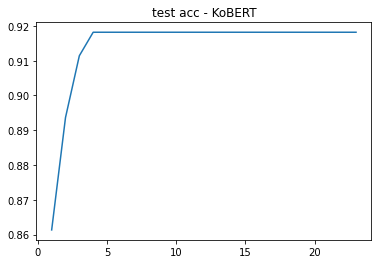

In [ ]:
# test acc
x = list(range(1,24))
y = [0.8613191244239632,0.8936491935483871,0.911434331797235,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585,0.9182027649769585]
plt.plot(x,y)
plt.title("test acc - KoBERT")
plt.show()